# Analyse et Prévision des Données des finances publiques à l'aide des Modèles ARIMA, VAR et LSTM

## Introduction

L'objectif de ce projet est d'analyser et de prévoir les données financières en utilisant divers modèles de séries temporelles. Le jeu de données comprend des caractéristiques financières clés telles que :

- **Date**: La date de l'enregistrement.
- **IS**: Impôt sur les sociétés.
- **IR**: Impôt sur le revenu.
- **TVA**: Taxe sur la valeur ajoutée.
- **TIC**: Taxe intérieure de consommation.
- **BetS**: Dépenses en biens et services.
- **intD**: Intérêt de la dette.
- **COMP**: Compensation.

Les modèles utilisés dans cette analyse sont ARIMA, VAR, LSTM et Isolation Forest pour la détection des anomalies. Chaque modèle est évalué à l'aide de métriques de performance telles que RMSE (Root Mean Squared Error) et MAPE (Mean Absolute Percentage Error).


### Import necessary libraries

In [2]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")


###  Load and prepare data


In [3]:
# Chemin du fichier Excel
data_path = 'C:\\Users\\moussaab\\Downloads\\updted.xlsx'

# Charger les données depuis le fichier Excel
df = pd.read_excel(data_path)

# Supprimer la colonne 'Unnamed: 8' si elle existe
if 'Unnamed: 8' in df.columns:
    df.drop(columns=['Unnamed: 8'], inplace=True)

# Convertir 'Date' en format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')

# Création des colonnes pour les totaux mensuels
df['Total Monthly Receipts'] = df[['IS', 'IR', 'TVA', 'TIC']].sum(axis=1)
df['Total Monthly Expenses'] = df[['BetS', 'intD', 'Comp']].sum(axis=1)


## Exploration et Visualisation des Données

Dans cette section, nous allons effectuer une analyse exploratoire des données (EDA) pour comprendre les tendances, la saisonnalité et les corrélations au sein des données financières.


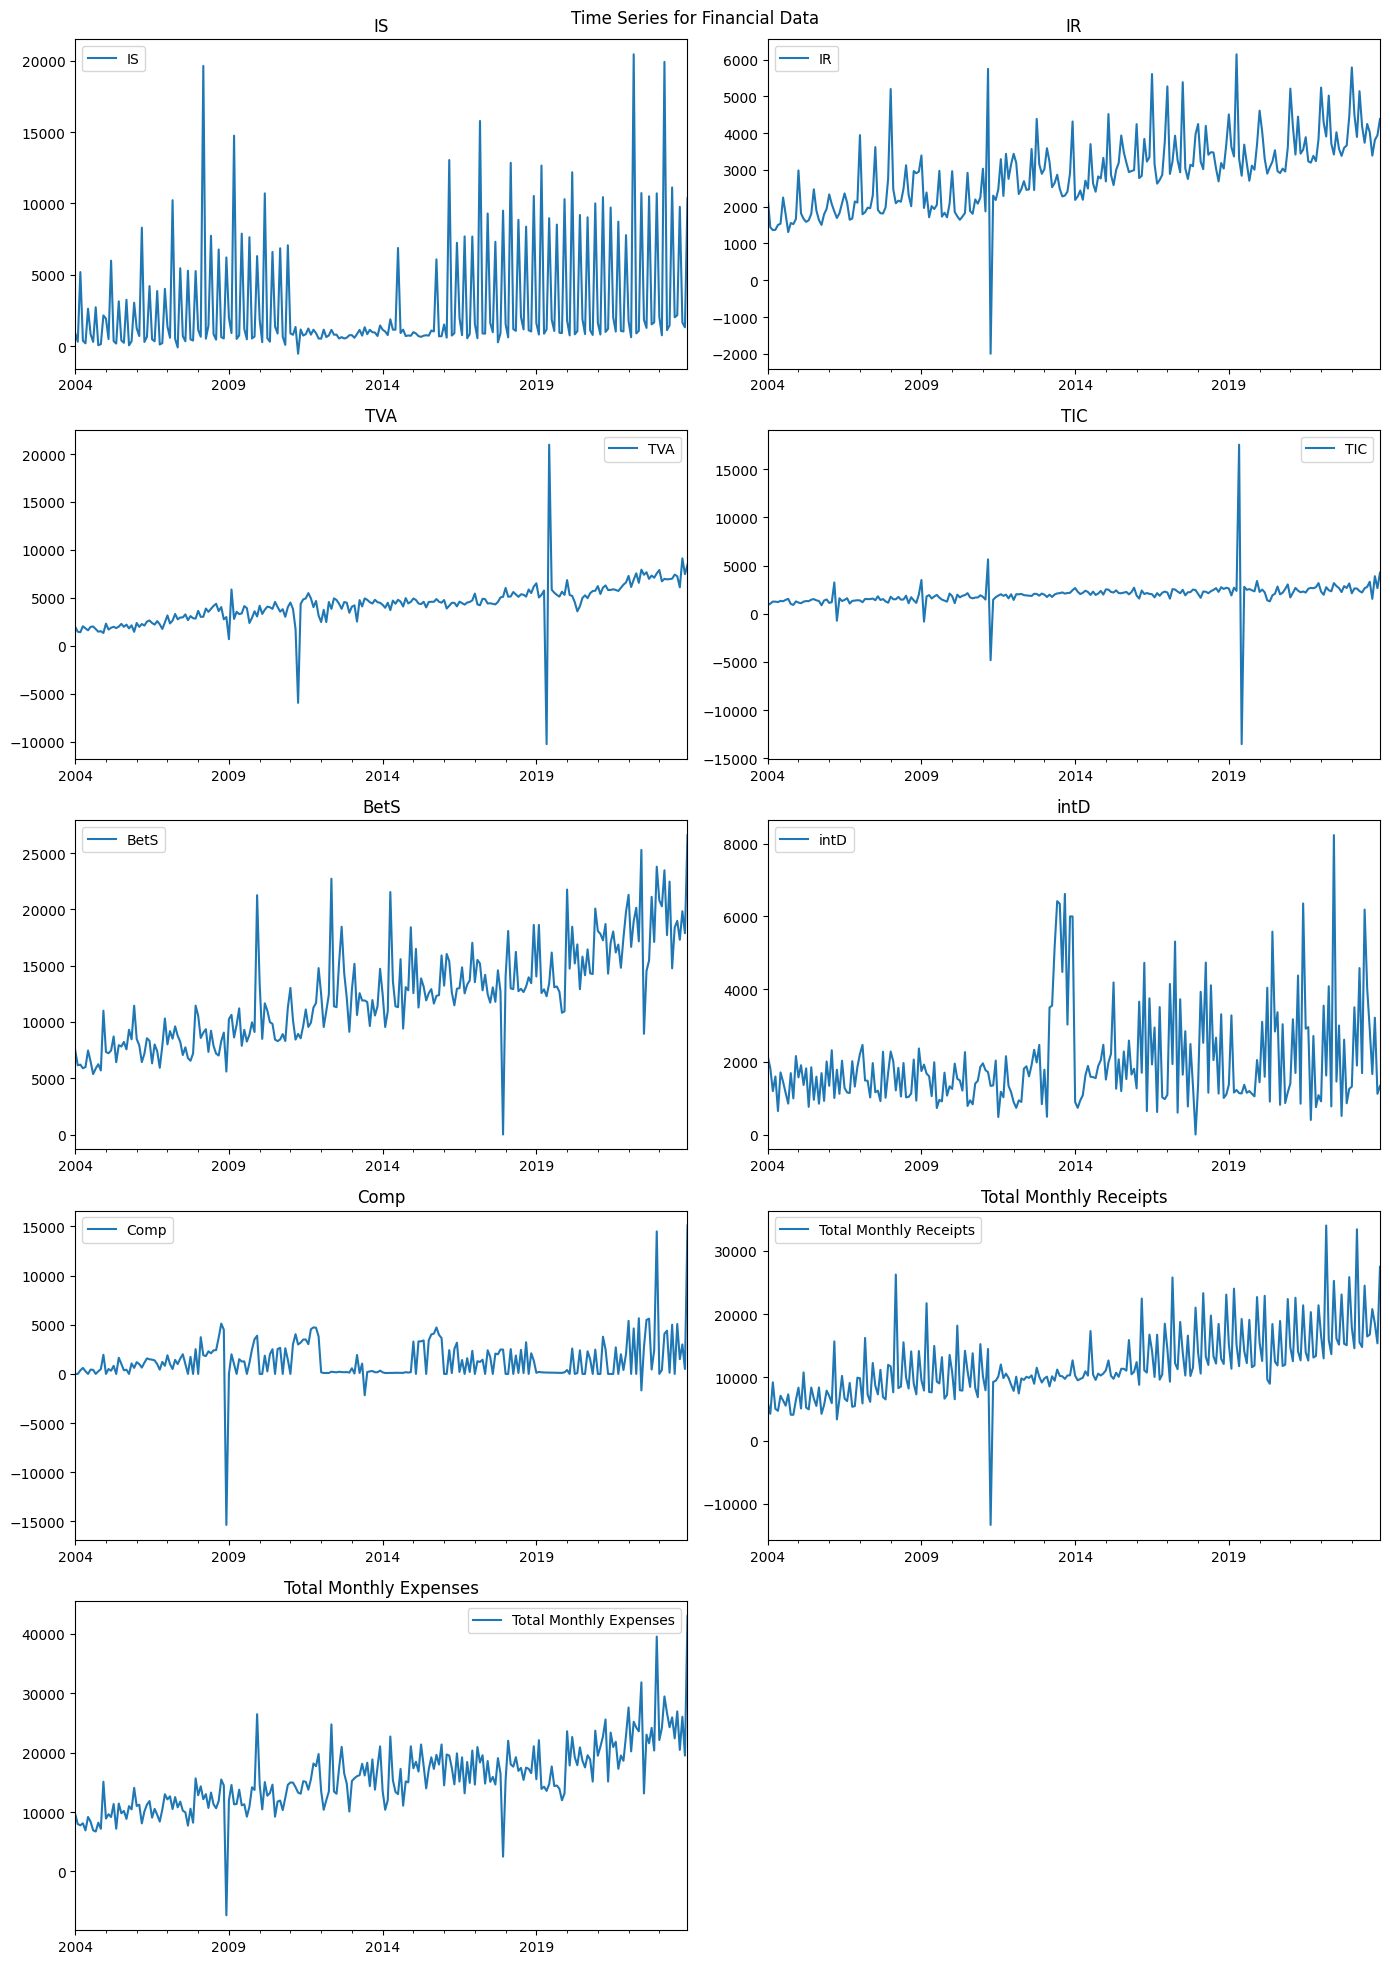

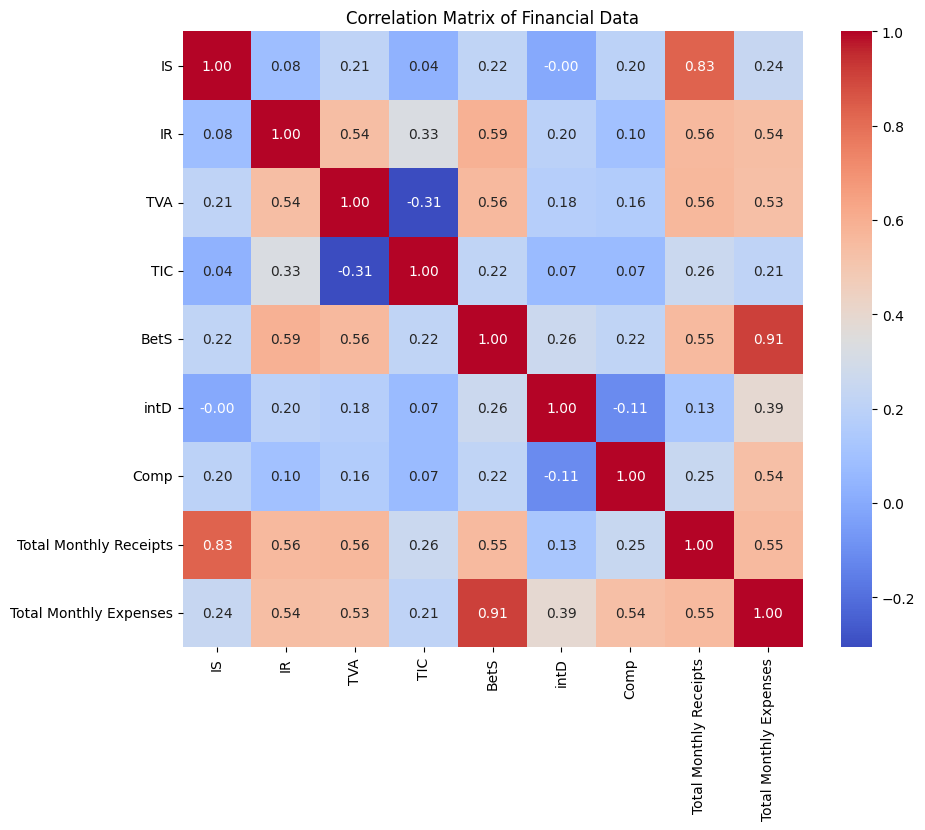

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Sélectionner toutes les colonnes sauf 'year' et 'Date'
columns_to_plot = [col for col in df.columns if col not in ['year', 'Date']]

# Plotting time series for each feature
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
fig.suptitle("Time Series for Financial Data")

for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    df.plot(x='Date', y=column, ax=axes[row, col], title=column)
    axes[row, col].set_xlabel('')  # Remove x-label for cleaner look

# Remove any unused subplots
for i in range(len(columns_to_plot), 10):
    row = i // 2
    col = i % 2
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[columns_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Financial Data')
plt.show()





### Tendances générales
- **Augmentation globale des recettes et des dépenses entre 2004 et 2023**
  - Reflet probable de la croissance économique générale et de l'inflation sur cette période.

### Analyse par indicateur

#### IS (Impôt sur les Sociétés)
- **Forte saisonnalité avec des pics réguliers**
  - Probablement liés aux échéances fiscales.
- **Volatilité accrue après 2014**
  - Possibles changements dans la politique fiscale.
  - Ou fluctuations économiques significatives.

#### TVA (Taxe sur la Valeur Ajoutée)
- **Tendance générale à la hausse**
- **Baisses importantes observées**
  - Potentiellement liées à des crises économiques majeures (ex: crise de 2008, pandémie COVID-19 en 2020).

#### IR (Impôt sur le Revenu)
- **Variations saisonnières marquées**
  - Reflète probablement les cycles de perception de l'impôt.

#### TIC (Taxe Intérieure de Consommation)
- **Relativement stable sur la période**
- **Quelques pics négatifs importants**
  - Possiblement dus à des remboursements ou des ajustements ponctuels.

#### BetS (Bénéfices et Salaires)
- **Tendance à la hausse**
- **Volatilité croissante**
  - Pourrait refléter l'évolution du marché du travail.
  - Et des changements dans les politiques salariales.

#### Comp (Compensations)
- **Variations importantes**
  - Possiblement liées à des politiques de subventions ou de compensations économiques.

#### Total des recettes et dépenses mensuelles
- **Augmentation générale sur la période**
- **Variations saisonnières observables**
- **Quelques baisses notables**
  - Probablement liées à des événements économiques majeurs.


Ces données offrent un aperçu de l'évolution des finances publiques sur près de deux décennies, reflétant les cycles économiques, les changements de politique fiscale et les événements majeurs ayant impacté l'économie nationale.


###  Anomaly detection with Isolation Forest



In [ ]:
# Détection des anomalies avancée avec Isolation Forest
def detect_anomalies_iforest(df, columns, contamination=0.05):
    isolation_forest = IsolationForest(contamination=contamination)
    df['anomaly'] = isolation_forest.fit_predict(df[columns])
    anomalies = df[df['anomaly'] == -1]
    return anomalies

anomalies = detect_anomalies_iforest(df, ['Total Monthly Receipts', 'Total Monthly Expenses'])
print("Anomalies détectées :")
print(anomalies)


Anomalies détectées :
          Date  year       IS      IR     TVA     TIC   BetS  intD   Comp  \
50  2008-03-01  2008  19633.0  2094.0  3026.0  1505.0   9048  1214   1901   
59  2008-12-01  2008   6209.0  2955.0  2992.0  2011.0   5595  2367 -15359   
87  2011-04-01  2011   -538.0 -1998.0 -5958.0 -4821.0   8938  1337   3000   
158 2017-03-01  2017  15774.0  3232.9  4223.7  2561.0  15188  1938   1220   
167 2017-12-01  2017   9488.9  3971.8  5105.0  2461.0      0     0   2482   
182 2019-03-01  2019  12648.0  3368.0  5310.0  2704.0  12571  1155    166   
218 2022-03-01  2022  20447.0  3911.0  6896.0  2758.0  18966  1623   4628   
221 2022-06-01  2022  10720.0  3420.0  7936.0  3180.0  25288  8235  -1679   
227 2022-12-01  2022  10701.0  4454.0  7551.0  3147.0  23801  1256  14500   
230 2023-03-01  2023  19917.0  3898.0  6977.0  2622.0  23483  1898   4091   
233 2023-06-01  2023  11113.0  3740.0  6997.0  2654.0  14767  6186   5000   
239 2023-12-01  2023  10370.0  4386.0  8451.0  4271.0 

#  Evaluation metrics functions


In [ ]:
# Fonction pour calculer RMSE et MAPE
def evaluate_forecast(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    return rmse, mape


#  ARIMA forecasting


In [ ]:
# Prévision avec ARIMA
def forecast_arima(time_series, steps=12):
    model = ARIMA(time_series, order=(1, 1, 1))
    fit_model = model.fit()
    forecast = fit_model.forecast(steps=steps)
    return forecast


#  VAR forecasting


In [ ]:
# Prévision avec VAR
def forecast_var(df_var, steps=12, lag_order=None):
    model = VAR(df_var)
    results = model.fit(maxlags=lag_order, ic=None)
    forecast_input = df_var.values[-lag_order:]
    forecast = results.forecast(y=forecast_input, steps=steps)
    return forecast


#  Visualization and Descriptive Statistics


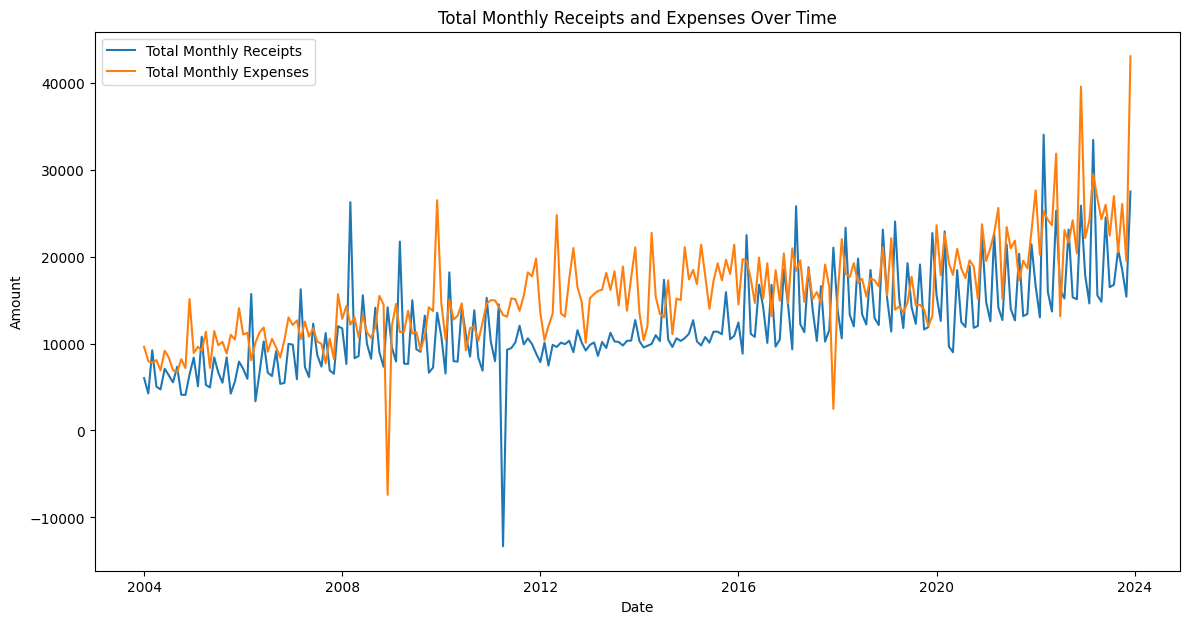

Statistiques descriptives des recettes mensuelles totales :
count      240.000000
mean     12091.756208
std       5517.507477
min     -13315.000000
25%       8957.250000
50%      10774.500000
75%      14526.000000
max      34012.000000
Name: Total Monthly Receipts, dtype: float64

Statistiques descriptives des dépenses mensuelles totales :
count      240.000000
mean     15716.625000
std       5679.919066
min      -7397.000000
25%      11850.250000
50%      14987.500000
75%      19114.250000
max      43041.000000
Name: Total Monthly Expenses, dtype: float64


In [ ]:
# Visualisation des données
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Total Monthly Receipts'], label='Total Monthly Receipts')
plt.plot(df['Date'], df['Total Monthly Expenses'], label='Total Monthly Expenses')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Total Monthly Receipts and Expenses Over Time')
plt.legend()
plt.show()

# Statistiques descriptives
print("Statistiques descriptives des recettes mensuelles totales :")
print(df['Total Monthly Receipts'].describe())
print("\nStatistiques descriptives des dépenses mensuelles totales :")
print(df['Total Monthly Expenses'].describe())


#  Stationarity test


In [ ]:
# Test de stationnarité
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationnaire' if result[1] < 0.05 else 'Non Stationnaire')

test_stationarity(df['Total Monthly Receipts'])
test_stationarity(df['Total Monthly Expenses'])


ADF Statistic: -0.1921199590683615
p-value: 0.9394544022839173
Non Stationnaire
ADF Statistic: 0.40889878769877025
p-value: 0.9818246909179589
Non Stationnaire


#  Make Receipts Data Stationary


In [ ]:
# Stationnariser les données de recettes mensuelles totales
df['Stationary Receipts'] = df['Total Monthly Receipts'].diff().dropna()
df['Stationary Expenses'] = df['Total Monthly Expenses'].diff().dropna()
# Vérifier la stationnarité des nouvelles données
test_stationarity(df['Stationary Receipts'].dropna())
test_stationarity(df['Stationary Expenses'].dropna())


ADF Statistic: -10.989814549334405
p-value: 7.106440630000365e-20
Stationnaire
ADF Statistic: -7.311833465574493
p-value: 1.2584589712003007e-10
Stationnaire


#  Select lag order for VAR


In [ ]:
# Choix du nombre de retards pour VAR
def select_lags(df, maxlags=15):
    model = VAR(df)
    results = model.fit(maxlags=maxlags, ic='aic')
    print(f'Optimal Lag Order based on AIC: {results.k_ar}')
    results = model.fit(maxlags=maxlags, ic='bic')
    print(f'Optimal Lag Order based on BIC: {results.k_ar}')
    results = model.fit(maxlags=maxlags, ic='hqic')
    print(f'Optimal Lag Order based on HQIC: {results.k_ar}')

df_var = df[['Total Monthly Receipts', 'Total Monthly Expenses']].dropna()
select_lags(df_var)


Optimal Lag Order based on AIC: 12
Optimal Lag Order based on BIC: 3
Optimal Lag Order based on HQIC: 12


#  ARIMA and VAR forecasting


In [ ]:
# Prévision des recettes et dépenses avec ARIMA
receipts_ts = df.set_index('Date')['Total Monthly Receipts']
expenses_ts = df.set_index('Date')['Total Monthly Expenses']
forecast_receipts_arima = forecast_arima(receipts_ts, steps=12)
forecast_expenses_arima = forecast_arima(expenses_ts, steps=12)

# Prévision des recettes et dépenses avec VAR
lag_order = 12  
forecast_var_result = forecast_var(df_var, steps=12, lag_order=lag_order)
forecast_df_var = pd.DataFrame(forecast_var_result, index=pd.date_range(start=df['Date'].iloc[-1], periods=12, freq='M'), 
                               columns=['Forecasted Receipts', 'Forecasted Expenses'])



#  Evaluate ARIMA and VAR forecasts


In [ ]:
# Évaluer les prévisions ARIMA
rmse_receipts_arima, mape_receipts_arima = evaluate_forecast(receipts_ts[-12:], forecast_receipts_arima)
rmse_expenses_arima, mape_expenses_arima = evaluate_forecast(expenses_ts[-12:], forecast_expenses_arima)

# Évaluer les prévisions VAR
rmse_receipts_var, mape_receipts_var = evaluate_forecast(receipts_ts[-12:], forecast_df_var['Forecasted Receipts'])
rmse_expenses_var, mape_expenses_var = evaluate_forecast(expenses_ts[-12:], forecast_df_var['Forecasted Expenses'])


#  Prepare data for LSTM


In [ ]:
# Préparation des données pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

def prepare_lstm_data(series, n_lag=12):
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(n_lag, len(scaled_data)):
        X.append(scaled_data[i-n_lag:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y)

X_receipts, y_receipts = prepare_lstm_data(receipts_ts)
X_expenses, y_expenses = prepare_lstm_data(expenses_ts)

X_receipts = X_receipts.reshape((X_receipts.shape[0], X_receipts.shape[1], 1))
X_expenses = X_expenses.reshape((X_expenses.shape[0], X_expenses.shape[1], 1))


# Build and train LSTM model


In [ ]:
# Construction et entraînement du modèle LSTM
def build_and_train_lstm(X, y, epochs=15, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

lstm_model_receipts = build_and_train_lstm(X_receipts, y_receipts)
lstm_model_expenses = build_and_train_lstm(X_expenses, y_expenses)


#  LSTM forecasting


In [ ]:
# Prévision avec LSTM
def forecast_lstm(model, series, steps=12, n_lag=12):
    scaled_data = scaler.transform(series.values.reshape(-1, 1))
    forecast = []
    current_batch = scaled_data[-n_lag:]
    current_batch = current_batch.reshape((1, n_lag, 1))
    for _ in range(steps):
        pred = model.predict(current_batch)[0]
        forecast.append(pred)
        current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)
    forecast = scaler.inverse_transform(forecast)
    return forecast.flatten()

forecast_receipts_lstm = forecast_lstm(lstm_model_receipts, receipts_ts)
forecast_expenses_lstm = forecast_lstm(lstm_model_expenses, expenses_ts)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


#  Evaluate LSTM forecasts


In [ ]:
# Évaluer les prévisions LSTM
rmse_receipts_lstm, mape_receipts_lstm = evaluate_forecast(receipts_ts[-12:], forecast_receipts_lstm)
rmse_expenses_lstm, mape_expenses_lstm = evaluate_forecast(expenses_ts[-12:], forecast_expenses_lstm)


#  Compare model performances


In [ ]:
# Comparaison des performances des modèles
performance_df = pd.DataFrame({
    'Model': ['ARIMA', 'ARIMA', 'VAR', 'VAR', 'LSTM', 'LSTM'],
    'Type': ['Receipts', 'Expenses', 'Receipts', 'Expenses', 'Receipts', 'Expenses'],
    'RMSE': [rmse_receipts_arima, rmse_expenses_arima, rmse_receipts_var, rmse_expenses_var, rmse_receipts_lstm, rmse_expenses_lstm],
    'MAPE': [mape_receipts_arima, mape_expenses_arima, mape_receipts_var, mape_expenses_var, mape_receipts_lstm, mape_expenses_lstm]
})

print(performance_df)


   Model      Type         RMSE       MAPE
0  ARIMA  Receipts  5781.182148  22.165936
1  ARIMA  Expenses  5798.383422  14.118015
2    VAR  Receipts  2289.509212   9.997066
3    VAR  Expenses  5046.051612  15.260807
4   LSTM  Receipts  5595.491799  24.291677
5   LSTM  Expenses  5878.899340  12.840710
